In [ ]:
# Til að nota gpu: starta tf_gpu environment og starta lab í rót verkefnis

import sys
#!pip install tensorflow[and-cuda]
!pip install tensorflow
!pip install keras

In [6]:
print("Python version")
print(sys.version)

Python version
3.10.14 | packaged by Anaconda, Inc. | (main, May  6 2024, 19:44:50) [MSC v.1916 64 bit (AMD64)]


In [8]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print("GPU found with ID: ", gpu)
else:
    print("Failed to detect GPU.")

GPU found with ID:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
#from tensorflow import keras
import keras

# REMINDER: keras modules should run despite missing import warnings (lazy loading?)
from keras.layers import TextVectorization

In [13]:
# Load the reviews dataset into a pandas DataFrame
df = pd.read_csv('data/total_reviews_text_and_label.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641799 entries, 0 to 641798
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  641799 non-null  int64 
 1   Texts       641799 non-null  object
 2   Label       641799 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 14.7+ MB


[]

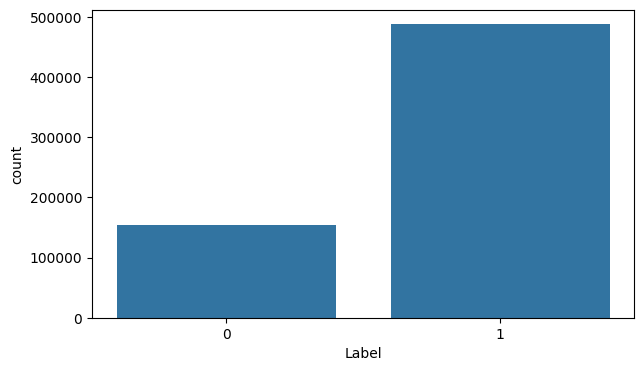

In [14]:
# Class division of positive and negative labels (User recommendations)
plt.figure(figsize=[7,4])
sns.countplot(x = df['Label'], data=df)
plt.plot()

# Skew may affect weight of classes? Check PyTorch WeightedRandomSampler for exmpl

In [15]:
### Dataset sample size for training ###
# Crashes with the complete dataset

n = 50000

df = df.sample(n)

In [19]:
import re
import string

# Processes review text to make it easier for the models to work with
def text_preprocess(text):
  text = re.sub(r'[^a-zA-Z\s]', "", text)
  # Remove punctuation marks
  text = re.sub(r'[^\w\s]', '', text)
  # Remove links
  text = re.sub(r'http\S+', '', text)
  text = text.replace('<unk>', 'UNKNOWN_TOKEN')

  arr = []
  for i in text:
    # Removes other symbols: !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
      if i in string.punctuation:
          arr.append("")
      else:
          arr.append(i)
  return "".join(arr).lower()

df["Texts"] = df["Texts"].apply(text_preprocess)

In [23]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
max_length = 2000
vocabs = 10000

# More text preprocessing specific to the model
def convert_to_number(text):
  tokenizer = Tokenizer(
      num_words=vocabs,
      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
      lower=True,
      split=' ',
      char_level=False,
      oov_token="<oov>",
      analyzer=None,
  )

  # Updates internal vocabulary based on word frequencies in the text
  tokenizer.fit_on_texts(text)
  # Converts text into the model's integer inputs
  sequence = tokenizer.texts_to_sequences(text)
  # Adds pad values to sequences to fit into fixed 2-d tensors
  pad_sequence = pad_sequences(sequence, padding="pre", maxlen=max_length)

  return pad_sequence

x = convert_to_number(df["Texts"])

In [24]:
x.shape

(50000, 2000)

In [26]:
# sklearn utily that splits arrays into random train and test subsets
# CURRENT SPLIT: test = 20%, train = 80%

from sklearn.model_selection import train_test_split
y = df["Label"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=32)

In [ ]:
from keras.layers import LSTM, Bidirectional, Dense, Embedding, Flatten, LSTM, Dropout, GRU
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras import Sequential
from keras import Model
from keras.callbacks import EarlyStopping

# Stops learning process to prevent overfitting
callback = EarlyStopping(patience=2, monitor='val_loss')

# Defines model composed of sequential layers
# Should be appropriate for single input (i.e. text analysis)
model = Sequential([
    Embedding(input_dim = vocabs, output_dim = 100, input_length=max_length),
    LSTM(128, recurrent_activation="sigmoid"),
    Dense(128, activation="relu"),
    Dropout(0.2),
    Dense(1, activation = "sigmoid"),
])

# Prints information on model
model.summary()

# Compiles model with chosen learning rate and loss function
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=BinaryCrossentropy(),
              metrics=["accuracy"],
              )

# Train model with chosen parameters
model.fit(x_train, y_train,
          epochs=20,
          validation_data=(x_test, y_test),
          batch_size=32,
          callbacks = callback
          )

In [ ]:
model.evaluate(x_test, y_test)

In [ ]:
# Save the model
model.save('keras_model')

# Load model:
# model = keras.models.load_model('keras_model')

In [ ]:
from wordcloud import WordCloud, STOPWORDS

# Function generates wordcloud with input data
def wc(data,bgcolor):
    plt.figure(figsize=(10,10))
    wc=WordCloud(background_color=bgcolor,stopwords=STOPWORDS)
    wc.generate(" ".join(data))
    plt.imshow(wc)
    plt.axis("off")

In [ ]:
# WordCloud with most frequent words found in reviews with positive label
df_positive = df[df['Label']==1]
wc(df_positive.Texts, "white")

In [ ]:
# WordCloud with most frequent words found in reviews with negative label
df_negative = df[df['Label']==0]
wc(df_negative.Texts, "white")

In [ ]:
# Aspects or themes to look for in review texts
aspects = {
    'music': [
        'sound', 'music', 'audio', 'instrument', 'soundtrack', 'voice acting',
        'song', 'sound effects', 'atmosphere', 'orchestra'
        ],
    'story': [
        'story', 'plot', 'narrative', 'character', 'mission', 'quest', 'writing',
        'dialogue', 'relationships', 'family', 'gods', 'lore', 'mythology', 'allies',
        'npc'
        ],
    'game play': [
        'gameplay', 'rogue-like', 'mechanics', 'controls', 'action', 'fight',
        'fights', 'attack', 'battle', 'weapon', 'moves', 'power', 'combat', 'upgrade',
        'multiplayer', 'pvp', 'pve', 'exploration'
        ],
    'visuals': [
        'visuals', 'graphics', 'art', 'images', 'color', 'artwork', 'animation',
        'lighting'
        ],
    'support': [
        'optimization', 'performance', 'framerate', 'frames', 'lag', 'netcode',
        'smooth', 'bugs', 'cheats', 'ban', 'developer', 'devs'
    ],
    'community': [
        'community', 'player base', 'player count', 'friends', 'cheaters', 'hackers'
    ]
}

custom_words = []
for aspect_words in aspects.values():
  custom_words.extend(aspect_words)

In [ ]:
# Finds frequency of the aspects defined above in review texts
def get_aspect_frequency(text):
  text_data = ' '.join(text)
  tokens = text_data.split()

  aspect_freq = {}
  for word in tokens:
    if word in custom_words:
      aspect_freq[word] = aspect_freq.get(word, 0) + 1
  return aspect_freq

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      contour_width=1, contour_color='steelblue',
                      max_words=100, random_state=42)

# Wordcloud of aspects mentioned in reviews with negative label
neg_freq = get_aspect_frequency(df_negative['Texts'])
wordcloud.generate_from_frequencies(neg_freq)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Wordcloud of aspects mentioned in reviews with positive label
pos_freq = get_aspect_frequency(df_positive['Texts'])
wordcloud.generate_from_frequencies(pos_freq)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()